# Timing Comparison: Python `nested_ot` vs. `solve_dynamic`

We take their code from:  [stephaneckstein/aotnumerics](https://github.com/stephaneckstein/aotnumerics)

In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
sys.path.append('../')
random_seed = 5
import time
import numpy as np

from pnot.utils import *
from pnot import nested_ot
from aot_numerics.aot_measure_to_path import *
from aot_numerics.mainfunctions import *
from aot_numerics.FVI_bench import *
from aot_numerics.normal_ot import *


# Parameters
grid_size = 0.2
n_runs = 10
n_sample = 100

L = np.array([[1,0,0,0],[2,2,0,0],[1,1,3,0],[2,2,1,2]])
M = np.array([[1,0,0,0],[2,1,0,0],[3,2,1,0],[4,3,2,1]])

rng = np.random.default_rng(42)
power = 2


## Functions to get the fomrating in their code

In [2]:
# 1) Common quantize helper
def quantize_path(adapted, v2q):
    # adapted: (T+1, n_samples) real; v2q: real→int code
    return np.array([[v2q[val] for val in path] for path in adapted.T], dtype=int)

def build_measure_from_q(q):
    # q: (n_samples, T+1) integer codes
    mu_x = qpath2mu_x(q, markovian=True)
    c,nc,v,w,next_idx,nv_cum,q2idx = list_repr_mu_x(mu_x, markovian=True)

    root_codes, counts = np.unique(q[:,0], return_counts=True)
    root_w            = counts / counts.sum()

    def mu(node, x_parents):
        if node == 0:
            return [root_codes.reshape(-1,1), list(root_w)]
        idx  = node - 1
        cond = (int(x_parents[0]),)
        i    = c[idx].index(cond)
        return [np.array(v[idx][i],int).reshape(-1,1),
                list(w[idx][i])]

    def sup_mu(nodes):
        if not nodes:
            return np.empty((0,1),dtype=int)
        t = nodes[0]
        return np.unique(q[:,t]).reshape(-1,1)

    return mu, sup_mu

    return mu, sup_mu
# --- build the Markov chain graph ---
T = L.shape[0]
g_markov = Graph(T+1)
for t in range(T):
    g_markov.addEdge(t, t+1)

## NON_MARKOV


# 2) Build measure for full-history
def build_measure_full(q):
    """
    q: np.ndarray shape (n_samples, T+1) of integer codes
    returns: mu(node, x_parents), sup_mu(nodes)
    """
    # build all prefix→next transitions
    mu_x = qpath2mu_x(q, markovian=False)
    c,nc,v,w,next_idx,nv_cum,q2idx = list_repr_mu_x(mu_x, markovian=False)

    # marginal at node 0
    root_codes, counts = np.unique(q[:,0], return_counts=True)
    root_w = counts / counts.sum()

    def mu(node, x_parents):
        if node == 0:
            return [root_codes.reshape(-1,1), list(root_w)]
        idx  = node - 1            # transitions X_{node} | X_{0:(node-1)}
        cond = tuple(int(x) for x in x_parents)
        i    = c[idx].index(cond)  # find the right conditional block
        codes   = np.array(v[idx][i], dtype=int).reshape(-1,1)
        weights = list(w[idx][i])
        return [codes, weights]

    def sup_mu(nodes):
        # return all unique joint codes over the given set of nodes
        if not nodes:
            return np.empty((0, len(nodes)), dtype=int)
        cols = list(nodes)
        arr  = q[:, cols]                       # shape (n_samples, len(nodes))
        uniq = np.unique(arr, axis=0)           # deduplicate rows
        return uniq                             # shape (#unique, len(nodes))

    return mu, sup_mu

# 3) Build the full-history DAG on T+1 nodes
T = L.shape[0]
g_full = Graph(T+1)
for i in range(T+1):
    for j in range(i+1, T+1):
        g_full.addEdge(i, j)


## Non-Markvoain Simlations

n_sample =  100
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  200
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  300
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  500
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  1000
run =  0
run =  1
run =  2
run =  3
run =  4


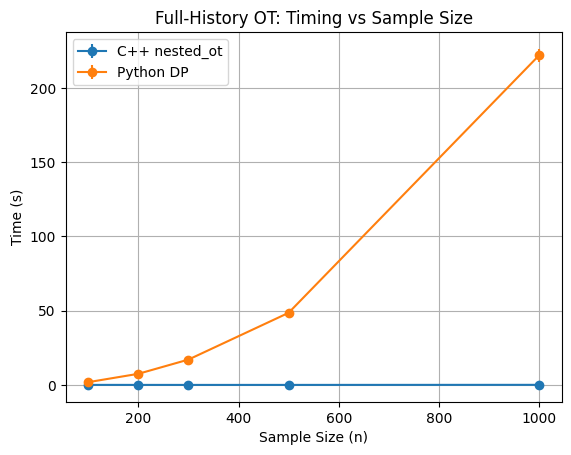

 n   |  C++ (mean ± std)   |  PyDP (mean ± std)   |  Speed-up (× faster in C++)
-----+---------------------+----------------------+----------------------------
 100 |   0.040 ± 0.011   |   1.866 ± 0.061    |    46.5×
 200 |   0.024 ± 0.010   |   7.490 ± 0.194    |   317.5×
 300 |   0.015 ± 0.004   |  17.061 ± 0.457    |  1124.9×
 500 |   0.019 ± 0.000   |  48.557 ± 0.897    |  2543.1×
1000 |   0.067 ± 0.014   |  221.924 ± 4.303    |  3292.6×

Max |Δ| = 1.0658141036401503e-14


In [3]:
import time


# Parameters
grid_size   = 0.2
power       = 2
num_threads = 250
n_runs      = 5
sample_sizes= [100, 200, 300, 500, 1000]

# Build full‐history graph on T+1 nodes
T = 4
g_full = Graph(T+1)
for i in range(T+1):
    for j in range(i+1, T+1):
        g_full.addEdge(i, j)

rng = np.random.default_rng(42)

# Storage
means_cpp = []
std_cpp   = []
means_py  = []
std_py    = []
dist_nested   = []
dist_dynamic  = []

for n_sample in sample_sizes:
    print("n_sample = ", n_sample)
    run_cpp = []
    run_py  = []
    for run in range(n_runs):
        print("run = ", run)
        seed1 = int(rng.integers(0,10000))
        X, _  = matrixL2paths(L, n_sample, seed=seed1)
        Y, _  = matrixL2paths(M, n_sample, seed=seed1)

        # C++ solver
        t0 = time.perf_counter()
        nested_dist  = nested_ot(X, Y,
                       grid_size=grid_size,
                       markovian=False,
                       num_threads=num_threads,
                       power=power)
        run_cpp.append(time.perf_counter()-t0)

        # Python DP
        X_ad = path2adaptedpath(X, grid_size)
        Y_ad = path2adaptedpath(Y, grid_size)
        all_vals = np.unique(np.concatenate([X_ad.ravel(), Y_ad.ravel()]))
        v2q = {v:i for i,v in enumerate(all_vals)}
        q2v = all_vals
        qX  = quantize_path(X_ad, v2q)
        qY  = quantize_path(Y_ad, v2q)
        mu, sup_mu = build_measure_full(qX)
        nu, sup_nu = build_measure_full(qY)

        cost = []
        for t in range(T+1):
            cost.append((
                [t],
                lambda x,y,p=power,q2v=q2v:
                  abs(q2v[int(x[0])] - q2v[int(y[0])])**p
            ))

        t1 = time.perf_counter()
        solve_dyn , _ = solve_dynamic(cost, mu, nu, sup_mu, sup_nu,
                              g_full, method='pot', outputflag=0)
        run_py.append(time.perf_counter()-t1)
        dist_dynamic.append(solve_dyn[0])
        dist_nested.append(nested_dist)

    means_cpp.append(np.mean(run_cpp))
    std_cpp.append( np.std(run_cpp))
    means_py.append( np.mean(run_py))
    std_py.append(  np.std(run_py))


# Plot
plt.errorbar(sample_sizes, means_cpp, yerr=std_cpp, label='C++ nested_ot', marker='o')
plt.errorbar(sample_sizes, means_py,  yerr=std_py,  label='Python DP',       marker='o')
plt.xlabel('Sample Size (n)')
plt.ylabel('Time (s)')
plt.title('Full‐History OT: Timing vs Sample Size')
plt.legend(); plt.grid(True)
plt.show()

# Summary table with speed-up factor
print(" n   |  C++ (mean ± std)   |  PyDP (mean ± std)   |  Speed-up (× faster in C++)")
print("-----+---------------------+----------------------+----------------------------")
for n, mc, sc, mp, sp in zip(sample_sizes, means_cpp, std_cpp, means_py, std_py):
    speedup = mp/mc
    print(f"{n:4d} |  {mc:6.3f} ± {sc:.3f}   |  {mp:6.3f} ± {sp:.3f}    |  {speedup:6.1f}×")

# final check
print("\nMax |Δ| =", np.max(np.abs(np.array(dist_nested)-np.array(dist_dynamic))))

# Markovian Simulations

n_sample =  200
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  600
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  1000
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  1500
run =  0
run =  1
run =  2
run =  3
run =  4
n_sample =  2000
run =  0
run =  1
run =  2
run =  3
run =  4


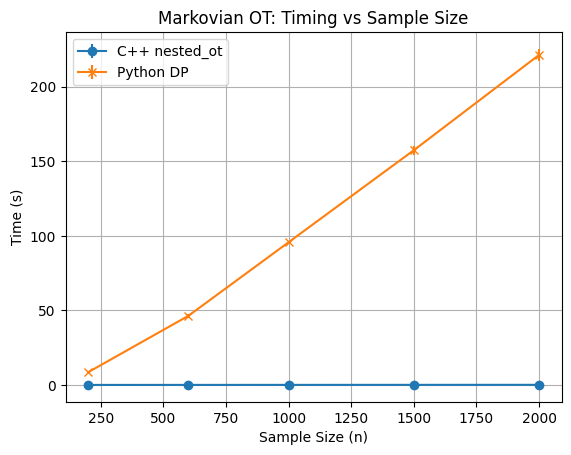

  n   | C++ mean ± std (s) | PyDP mean ± std (s) | Speed‐up (×)
------+---------------------+----------------------+------------
 200 |   0.007 ±0.000     |   8.531 ±0.187      |   1224.3×
 600 |   0.022 ±0.001     |   46.357 ±0.982      |   2120.2×
1000 |   0.036 ±0.000     |   95.701 ±0.924      |   2637.6×
1500 |   0.052 ±0.001     |   157.432 ±2.981      |   3002.5×
2000 |   0.069 ±0.001     |   221.344 ±4.013      |   3215.8×

Max |Δ| = 2.3092638912203256e-14


In [12]:
import time

# ------------------------------------------------------------------------
# 1) Parameters & helper Cholesky functions
# ------------------------------------------------------------------------
time_steps   = 10
n_runs       = 5
sample_sizes = [200, 600, 1000, 1500, 2000]
grid_size    = 0.1
power        = 2
num_threads  = 20
rng          = np.random.default_rng(42)

def integrated_process_matrix(T, variance):
    return np.tril(np.ones((T, T))) * np.sqrt(variance)

def ar1_cholesky_matrix(T, phi, sigma):
    L = np.zeros((T, T))
    for t in range(T):
        for j in range(t+1):
            if j == 0:
                L[t, j] = sigma * (phi**t) / np.sqrt(1 - phi**2)
            else:
                L[t, j] = sigma * (phi**(t - j))
    return L


# ------------------------------------------------------------------------
# 3) Build the Markov chain graph
# ------------------------------------------------------------------------
g_markov = Graph(time_steps+1)
for t in range(time_steps):
    g_markov.addEdge(t, t+1)

# ------------------------------------------------------------------------
# 4) Benchmark loop
# ------------------------------------------------------------------------
means_cpp = []
std_cpp   = []
means_py  = []
std_py    = []
dist_nested   = []
dist_dynamic  = []

for n_sample in sample_sizes:
    cpp_times = []
    py_times  = []
    print("n_sample = ", n_sample)

    for run in range(n_runs):
        seed = int(rng.integers(0, 10_000))
        print("run = ", run)

        # a) Generate Markovian paths
        Lx = integrated_process_matrix(time_steps, 0.25)
        Ly = ar1_cholesky_matrix(time_steps, 0.8, 1.0)
        X, _ = matrixL2paths(Lx, n_sample, seed=seed)
        Y, _ = matrixL2paths(Ly, n_sample, seed=seed)

        # b) C++ nested_ot (Markovian)
        t0 = time.perf_counter()
        nested_dist  = nested_ot(
            X, Y,
            grid_size=grid_size,
            markovian=True,
            num_threads=num_threads,
            power=power
        )

        cpp_times.append(time.perf_counter() - t0)

        # c) Python DP (Markovian)
        # quantize both on same grid
        X_ad = path2adaptedpath(X, grid_size)
        Y_ad = path2adaptedpath(Y, grid_size)
        all_vals = np.unique(np.concatenate([X_ad.ravel(), Y_ad.ravel()]))
        v2q = {v:i for i,v in enumerate(all_vals)}

        qX = quantize_path(X_ad, v2q)
        qY = quantize_path(Y_ad, v2q)

        mu,  sup_mu  = build_measure_from_q(qX)
        nu,  sup_nu  = build_measure_from_q(qY)

        cost = [
            (
                [t],
                lambda x, y, p=power, q2v=all_vals:
                  abs(q2v[int(x[0])] - q2v[int(y[0])])**p
            )
            for t in range(time_steps+1)
        ]

        t1 = time.perf_counter()
        solve_dyn , _ = solve_dynamic(
            cost, mu, nu, sup_mu, sup_nu,
            g_markov, method='pot', outputflag=0
        )
        py_times.append(time.perf_counter() - t1)
        dist_dynamic.append(solve_dyn[0])
        dist_nested.append(nested_dist)

        

    means_cpp.append(np.mean(cpp_times))
    std_cpp.append(np.std(cpp_times))
    means_py.append(np.mean(py_times))
    std_py.append(np.std(py_times))

# ------------------------------------------------------------------------
# 5) Plot and summary
# ------------------------------------------------------------------------
plt.errorbar(sample_sizes, means_cpp, yerr=std_cpp, marker='o', label='C++ nested_ot')
plt.errorbar(sample_sizes, means_py,  yerr=std_py,  marker='x', label='Python DP')
plt.xlabel('Sample Size (n)')
plt.ylabel('Time (s)')
plt.title('Markovian OT: Timing vs Sample Size')
plt.legend(); plt.grid(True)
plt.show()

print("  n   | C++ mean ± std (s) | PyDP mean ± std (s) | Speed‐up (×)")
print("------+---------------------+----------------------+------------")
for n, mc, sc, mp, sp in zip(sample_sizes, means_cpp, std_cpp, means_py, std_py):
    print(f"{n:4d} |   {mc:.3f} ±{sc:.3f}     |   {mp:.3f} ±{sp:.3f}      |   {mp/mc:5.1f}×")

# final check
print("\nMax |Δ| =", np.max(np.abs(np.array(dist_nested)-np.array(dist_dynamic))))